### 1. Import data analysis libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train_ID = train['Id']
test_ID = test['Id']

# drop ID for now, b/c you don't want to mix it with other numerical features 
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# df is the merged dataset (train + test)
df = pd.concat((train, test)).reset_index(drop=True)

C:\Users\mcui1\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## 2. Overall EDA (Distribution by variable)

In [3]:
# helper function to visualize distribution
def visdist(df,col):
    plt.subplot(1, 2, 1)
    plt.hist(df[col])
    plt.subplot(1, 2, 2)
    plt.scatter(df[col],df['SalePrice'])
    plt.tight_layout()
    plt.show()
    
cat_colnames = df.select_dtypes(include=['object']).columns
#print(cat_colnames, len(cat_colnames))
num_colnames = df.select_dtypes(exclude = ["object"]).columns
#print(num_colnames,len(num_colnames))

#### 2.1 Observe Y (Sales Price) Distribution

C:\Users\mcui1\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


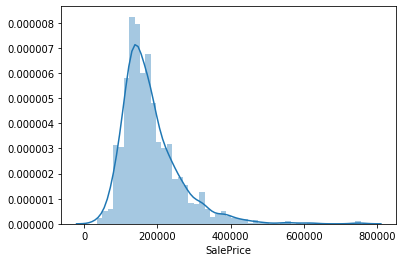

In [4]:
train['SalePrice'].describe()
sns.distplot(train['SalePrice'])

# as we can tell, it is skewed. 

C:\Users\mcui1\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


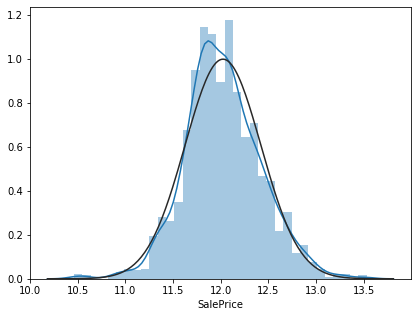

In [5]:
# Apply transformation (take log of Y)
train.SalePrice = np.log1p(train.SalePrice)

# New prediction
y_train = train.SalePrice.values
y = y_train
y_train_orig = train.SalePrice

# Now log(Y) is more normally distributed 
# Notice that we are only transforming Y for training data. 
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])

In [6]:
# Missing data in train
df_na = df.isnull().sum()
df_na = df_na[df_na>0]
df_na.sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [7]:
# missing data percentage plot 
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


## 3. Data Cleaning: Missing Value Imputation

In [40]:
def clean(df):
    # Turn number into string
    for var in ['MSSubClass']:
        # later on, change to the actual string values
        df[var] = df[var].apply(str)
        
    # The following numerical variables: NA = 0; fill NA with 0.
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
        df[col] = df[col].fillna(0).astype(int)
        
    # Replacing missing data with None, based on data description
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
        df[col] = df[col].fillna('None')
            
    # The following categorical variable: NA = typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    # lot frontage: correlated with lot area (0.48) and neighborhoods (domain expertise)
    df = cleanLotFrontage(df)

    # The following categorical variable: only few missing, take the most common value
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
        
    common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
    for var in common_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
    
    return df

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# Frontage is the lot line separating a lot from the street layout line. The minimum required frontage depends 
# on the zoning district in which a property is located as well as the proposed use.

def cleanLotFrontage(df):
    df['LotArea_bin'] = pd.cut(df['LotArea'],50).apply(lambda x: x.mid)
    df['Lotfrontage_grouped'] = df.groupby(['Neighborhood','LotArea_bin'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['Lotfrontage_grouped'] = df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    #df['LotFrontage_neigh'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    #df['LotFrontage_lotarea'] = df.groupby('LotArea')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['LotFrontage'] = df['Lotfrontage_grouped']
    df = df.drop(columns=['LotArea_bin','Lotfrontage_grouped']) 
    return df

In [6]:
def computeMissingness(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    # df.boxplot(column='LotFrontage',by='Neighborhood')
    # plt.scatter(x=df.LotArea,y=df.LotFrontage)
    return missing_data

In [7]:
# clean the data and compute the % of missingness to confirm
# this make sense, as the test dataset does NOT have sales price 
df = clean(df)
computeMissingness(df).head(10)

,Total,Percent
SalePrice,1459,0.499829
Electrical,0,0.000000
ExterCond,0,0.000000
ExterQual,0,0.000000
Exterior1st,0,0.000000
Exterior2nd,0,0.000000
Fence,0,0.000000
FireplaceQu,0,0.000000
Fireplaces,0,0.000000
Foundation,0,0.000000


### Data transformation - adjust skewness of numerical variables 

In [8]:
# Make the distinguishment between numerical vs. categorical for easier analysis
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = df[numerical_features]
feat_cat = df[categorical_features]


Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQua

In [9]:
# Those years are not really numerical, need to remove from feat_num
# Otherwise it intervenes our skewness adjustment that is designed specifically for real numerical features. 
feat_num = feat_num.drop('YearBuilt',axis =1)
feat_num = feat_num.drop('YearRemodAdd',axis =1)
feat_num = feat_num.drop('YrSold',axis =1)
feat_num = feat_num.drop('GarageYrBlt',axis =1)

feat_num

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
0,856,854,0,3,706,0,1,0,150,0,...,2,61,5,7,0,208500.0,0,8,856,0
1,1262,0,0,3,978,0,0,1,284,0,...,5,0,8,6,0,181500.0,0,6,1262,298
2,920,866,0,3,486,0,1,0,434,0,...,9,42,5,7,0,223500.0,0,6,920,0
3,961,756,0,3,216,0,1,0,540,272,...,2,35,5,7,0,140000.0,0,7,756,0
4,1145,1053,0,4,655,0,1,0,490,0,...,12,84,5,8,0,250000.0,0,9,1145,192
5,796,566,320,1,732,0,1,0,64,0,...,10,30,5,5,0,143000.0,0,5,796,40
6,1694,0,0,3,1369,0,1,0,317,0,...,8,57,5,8,0,307000.0,0,7,1686,255
7,1107,983,0,3,859,32,1,0,216,228,...,11,204,6,7,0,200000.0,0,7,1107,235
8,1022,752,0,2,0,0,0,0,952,205,...,4,0,5,7,0,129900.0,0,8,952,90
9,1077,0,0,2,851,0,1,0,140,0,...,1,4,6,5,0,118000.0,0,5,991,0


In [10]:
# we need to transform those numerical features where skewness is > 0.5
# abs(skewness)>1  highly sknewed 
# 1 > abs(skewness) > 0.5 moderately sknewed
# we are taking the conservative approach and adjusting for moderately skewed 

skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))

from scipy.stats import skew 
skewness.sort_values(ascending=False)

There are 25 skewed numerical features to Box Cox transform
Mean skewnees: 4.577754851899214


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
dtype: float64

In [11]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    feat_num[feat] = boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))
    df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
    
skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)



C:\Users\mcui1\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\mcui1\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


There are 16 skewed numerical features after Box Cox transform
Mean skewnees: 3.638213816276551


PoolArea         14.985994
3SsnPorch         8.865144
LowQualFinSF      8.495602
MiscVal           5.239894
BsmtHalfBath      3.780960
KitchenAbvGr      3.779896
ScreenPorch       3.153911
BsmtFinSF2        2.579468
EnclosedPorch     2.150157
MasVnrArea        0.976354
2ndFlrSF          0.894536
WoodDeckSF        0.784768
HalfBath          0.730771
OpenPorchSF       0.621025
BsmtFullBath      0.618419
Fireplaces        0.554522
dtype: float64

#####  We moved from 25 skewned numerical data to 16 skewed. That's an accomplishment! 

### Dummify 

In [12]:
# one liner code to dummify categorical variables 
df = df.drop("SalePrice", axis = 1)
final_features = pd.get_dummies(df)

### Check for multiColinearity

In [13]:
# Correlation with the SalePrice variable
corr = train.corr()['SalePrice']
corr[np.argsort(corr, axis=0)[::-1]] 

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64

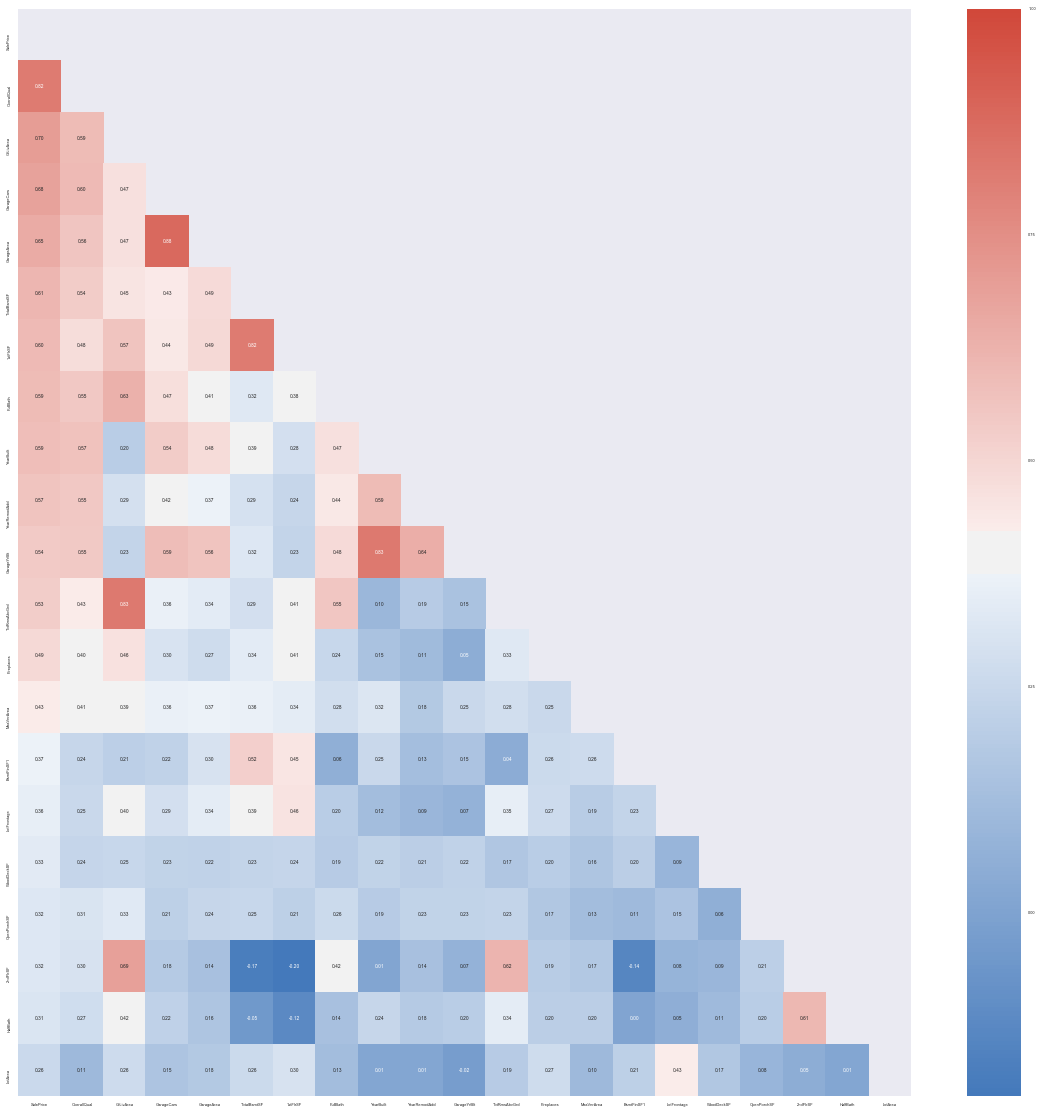

In [13]:
corr = train[train.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.25)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(250, 15, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.4)
plt.show()
del corr, dropSelf, top_corr

In [15]:
correlations = train.corr()
correlations = correlations.iloc[:36, :36] 
cut_off = 0.5
high_corrs = correlations[correlations.abs() > cut_off][correlations.abs() != 1].unstack().dropna().to_dict()
high_corrs = pd.Series(high_corrs, index = high_corrs.keys())
high_corrs = high_corrs.reset_index()
high_corrs = pd.DataFrame(high_corrs)
high_corrs.columns = ['1stAttribute', '2ndAttribute', 'Correlations']
high_corrs['Correlations'] = high_corrs['Correlations'].drop_duplicates(keep = 'first')
high_corrs.dropna().sort_values(by = 'Correlations', ascending = False)

,1stAttribute,2ndAttribute,Correlations
52,GarageCars,GarageArea,0.882475
10,YearBuilt,GarageYrBlt,0.825667
31,GrLivArea,TotRmsAbvGrd,0.825489
19,TotalBsmtSF,1stFlrSF,0.819530
22,2ndFlrSF,GrLivArea,0.687501
39,BedroomAbvGr,TotRmsAbvGrd,0.676620
16,BsmtFinSF1,BsmtFullBath,0.649212
14,YearRemodAdd,GarageYrBlt,0.642277
29,GrLivArea,FullBath,0.630012
25,2ndFlrSF,TotRmsAbvGrd,0.616423


### Data engineering  - from above, we definitely see some high correlation between variables that deal with "area".  Here we are combining some area-related variable.

In [16]:
#  Adding total sqfootage feature 
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#  Adding total bathrooms feature
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

#  Adding total porch sqfootage feature
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

In [17]:
# Just make sure one more time that we are capturing the right data for train & test 
print(final_features.shape)
X= final_features.iloc[:len(y_train), :]
X_test = final_features.iloc[len(y_train):, :]
X.shape, y_train.shape, X_test.shape


print(X.shape,y_train.shape,X_test.shape)

(2919, 318)
(1460, 318) (1460,) (1459, 318)


### Modeling 

In [32]:
# Import all the necessary packages for modeling 
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#### Functinalize things before starting:

In [19]:
# Write the CV and RMSE function beforehead 
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Park the range of values that the model considers each time in runs 
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

#### Build up models 

In [44]:
# Pipeline allows us to cross-validate models together
# while setting different parameters.Otherwise, we have to take repetitive steps to CV models (too manual)
# http://www.marcosantoni.com/2016/06/19/a-simple-machine-learning-pipeline.html
# Did not use Grid Search as that is extremely time consuming, so we opted for pipeline instead (i.e.set up hyperparameters using pipeline)

# Ridge
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO 
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net 
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
# lightgbm
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=8000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2, 
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
# xgboost 
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# Gradient Boosting
gbst = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =111)

# Random Forest 

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, 16)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = kfolds, verbose=2, random_state=42, n_jobs = -1)


In [42]:
# This is the list of models we are running 
models = {
          'ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm,
          'xgboost': xgboost,
          'gbst':gbst,
          'rf':rf}
predictions = {}
scores = {}

#### Now, train models 

In [43]:
# write a function to calculate RMSE of models 
for name, model in models.items():
    y = y_train
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

C:\Users\mcui1\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Calculate RMSE of each model on training data & test data

In [39]:
# # ridge
score = cv_rmse(ridge)
print("Ridge score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# # lasso 
score = cv_rmse(lasso)
print("Lasso score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# # elastic net 
score = cv_rmse(elasticnet)
print("ElasticNet score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# # lightgbm
score = cv_rmse(lightgbm)
print("lightgbm score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# # xgboost 
score = cv_rmse(xgboost)
print("xgboost score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# gbst
score = cv_rmse(gbst)
print("gradient boosting score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))

# rf
score = cv_rmse(rf)
print("rf score: train {:.4f} test {:.4f}\n".format(score.mean(), score.std()))


Ridge score: train 0.1271 test 0.0294

Lasso score: train 0.1254 test 0.0316

ElasticNet score: train 0.1249 test 0.0316

lightgbm score: train 0.1208 test 0.0195

xgboost score: train 0.1175 test 0.0214

xgboost score: train 0.1219 test 0.0220

rf score: train 0.1494 test 0.0280



#### Now that we have random forest, it's time to use that to see feature importance 
#### Can add this part to EDA part during presentation 

In [46]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                         score
OverallQual            0.535738
GrLivArea              0.125001
TotalBsmtSF            0.05953
GarageCars             0.027933
GarageArea             0.0245537
YearBuilt              0.0235846
BsmtFinSF1             0.020931
1stFlrSF               0.0140092
OverallCond            0.0124859
LotArea                0.00959521
CentralAir_N           0.00892256
YearRemodAdd           0.00859847
FireplaceQu_None       0.00802164
LotFrontage            0.00732259
CentralAir_Y           0.00720472
GarageType_Detchd      0.00662358
GarageYrBlt            0.00647148
BsmtUnfSF              0.00587755
OpenPorchSF            0.00483738
2ndFlrSF               0.00420537
WoodDeckSF             0.00377644
MoSold                 0.00348919
LotShape_Reg           0.00316304
MasVnrArea             0.00258093
EnclosedPorch          0.00246972
MSZoning_RM            0.00239761
KitchenQual_Ex         0.00211851
TotRmsAbvGrd           0.00178272
FullBath               0.001

#### Fit the training data X, y

In [54]:
print('----START Fit----',datetime.now())

print('Elasticnet')
elastic_model = elasticnet.fit(X, y)

print('Lasso')
lasso_model = lasso.fit(X, y)

print('Ridge')
ridge_model = ridge.fit(X, y)

print('lightgbm')
lgb_model = lightgbm.fit(X, y)

print('xgboost')
xgboost_model = xgboost.fit(X, y)

print('gbst')
gbst_model = gbst.fit(X, y)

print('rf')
rf_model = rf.fit(X, y)

----START Fit---- 2019-07-28 08:57:23.424931
Elasticnet
Lasso
Ridge
lightgbm
xgboost
gbst
rf


C:\Users\mcui1\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Stack the models!

In [56]:
avg = 1/7
avg

0.14285714285714285

In [59]:
stack_models = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm, xgboost,gbst,rf),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)
def stacked_models_final(X):
    return ((avg  * elastic_model.predict(X)) + \
            (avg * lasso_model.predict(X)) + \
            (avg * ridge_model.predict(X)) + \
            (avg * lgb_model.predict(X)) + \
            (avg * xgboost_model.predict(X)) + \
            (avg * gbst_model.predict(X)) + \
            (avg * rf_model.predict(X)))

In [60]:
print('RMSLE score on train data:')
print(rmsle(y, stacked_models_final(X)))

RMSLE score on train data:
0.07252896465086127


In [62]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = (np.expm1(stacked_models_final(X_test)))
submission.to_csv("submission_07.28.19.csv", index=False)